In [1]:
import os

# change to the root directory of the project
if os.getcwd().endswith("shap"):
    os.chdir("..")  

In [2]:
from src.vae import VanillaVAE, VAEDataModule

data = VAEDataModule(nan_rate=0.7, num_workers=8, val_batch_size=200)
data.setup()

reading data...
filtering data for training...


  0%|          | 0/55273 [00:00<?, ?it/s]

In [3]:
vae_model = VanillaVAE.load_from_checkpoint("logs/VAE/nan_0.7_xyz/checkpoints/last.ckpt")
vae_model = vae_model.to('cpu')

In [4]:
from pytorch_lightning import LightningDataModule
import torch

def get_ith_batch(data: LightningDataModule, i: int):
    for batch in data.val_dataloader():
        if i == 0:
            return batch
        i -= 1


def get_decoder_input(input: torch.Tensor, label: dict):
    mu, log_var = vae_model.encode(input)
    latent = vae_model.reparameterize(mu, log_var)
    decoder_input = torch.cat([latent, *[label[dim].unsqueeze(1).float() for dim in ["x", "y", "z"]]], dim=1)
    return decoder_input

In [5]:
batch0 = get_ith_batch(data, 0)
batch1 = get_ith_batch(data, 1)

In [6]:
from torch import nn

import shap


class ShapWrapper(nn.Module):
    def __init__(self, vae_model: VanillaVAE):
        super().__init__()
        self.vae_model = vae_model

    def forward(self, x):
        return self.vae_model.decode(x)


input0, label0 = batch0
backgrounds = get_decoder_input(input0, label0)
model = ShapWrapper(vae_model)
explainer = shap.DeepExplainer(model, backgrounds)

In [7]:
input1, label1 = batch1
decoder_input = get_decoder_input(input1, label1)
shap_values = explainer.shap_values(decoder_input)

In [8]:
import shap
shap.initjs()

In [9]:
import numpy as np

importance = np.abs(shap_values).mean(axis=2).mean(axis=0)
importance = np.array([importance[:-3].sum(), *importance[-3:]])
importance = importance / importance.sum()
importance

array([0.85063326, 0.09961337, 0.02557619, 0.02417718])

In [19]:
from shap import Explanation

oxy_shap = np.abs(shap_values[:, :-3]).sum(axis=1, keepdims=True)
xyz_shap = shap_values[:, -3:]

shap_val = np.concatenate([oxy_shap, xyz_shap], axis=1)

data = decoder_input.detach().numpy()
data = np.concatenate([data[:, :-3].sum(axis=1, keepdims=True), data[:, -3:]], axis=1)

explanation = Explanation(
    shap_val,
    data=data,
    feature_names=["Oxygen", "X", "Y", "Z"],
)

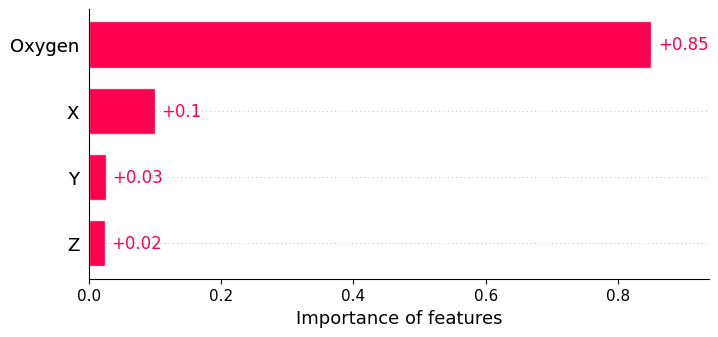

In [21]:
import shap
import matplotlib.pyplot as plt

impact = explanation.abs.mean(axis=2)

shap.plots.bar(
    impact / impact.mean(axis=0).sum().values,
    show=False,
    order=range(4)
)

plt.xlabel("Importance of features")
plt.show()

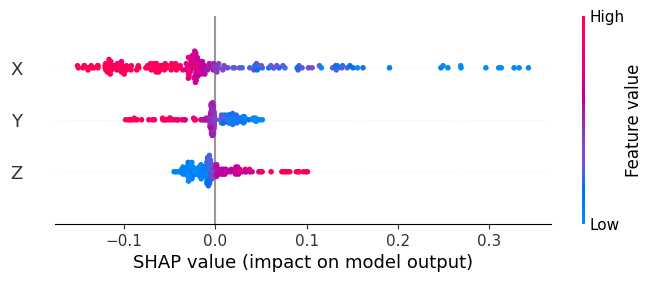

In [12]:
xyz_explanation = explanation[:, -3:]
xyz_explanation.values = xyz_explanation.values.mean(axis=2)

shap.plots.beeswarm(xyz_explanation, order=range(3))

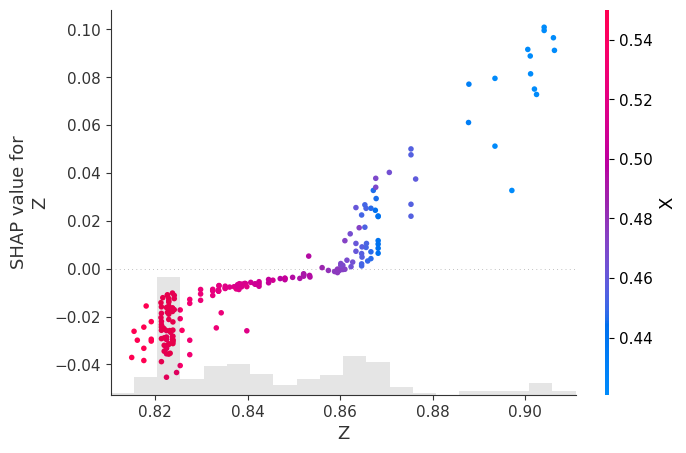

In [15]:
shap.plots.scatter(xyz_explanation[:, 'Z'], xyz_explanation[:, 'X'])